In [29]:
import numpy as np
#from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
import matplotlib.pyplot as plt

from livelossplot import PlotLossesKeras

import matplotlib.pyplot as plt

import  tensorflow as tf
import keras.backend.tensorflow_backend as tfback

def _get_available_gpus():  

    if tfback._LOCAL_DEVICES is None:  
        devices = tf.config.list_logical_devices()  
        tfback._LOCAL_DEVICES = [x.name for x in devices]  
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]


tfback._get_available_gpus = _get_available_gpus

from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())


['/device:CPU:0', '/device:XLA_CPU:0']


In [25]:
# fixar random seed para se puder reproduzir os resultados
seed = 9
np.random.seed(seed)

In [30]:
# Etapa 1 - preparar o dataset
'''
fazer o download do MNIST dataset com imagens de digitos escritos à mão para fazer a
sua classificação (já pré-preparados)
dataset: https://s3.amazonaws.com/img-datasets/mnist.npz
O ficheiro já tem tudo separado nos ficheiros {x_test.npy, x_train.npy, y_test.npy,
y_train.npy}
Os atributos de entrada estão com matrizes 3D(imagem, largura,altura) e os atributos de
saída é uma lista com o número correspondente
'''
def load_mnist_dataset(path='mnist.npz'):
    #path = get_file(path, origin='https://s3.amazonaws.com/img-datasets/mnist.npz')
    f = np.load(path)
    x_train = f['x_train']
    y_train = f['y_train']
    x_test = f['x_test']
    y_test = f['y_test']
    f.close()
    return (x_train, y_train), (x_test, y_test)

# Visualizar 6 imagens do mnist numa escala de cinzentos
def visualize_mnist():
    (X_train, y_train), (X_test, y_test) = load_mnist_dataset('mnist.npz')
    plt.subplot(321)
    plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
    plt.subplot(322)
    plt.imshow(X_train[1], cmap=plt.get_cmap('gray'))
    plt.subplot(323)
    plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))
    plt.subplot(324)
    plt.imshow(X_train[3], cmap=plt.get_cmap('gray'))
    plt.subplot(325)
    plt.imshow(X_train[4], cmap=plt.get_cmap('gray'))
    plt.subplot(326)
    plt.imshow(X_train[5], cmap=plt.get_cmap('gray'))
    plt.show()
    
# Etapa 2 - Definir a topologia da rede (arquitectura do modelo) e compilar (multilayer_perceptrons)
'''
cria-se um modelo sequencial e vai-se acrescentando camadas (layers)
vamos criar uma rede simples com uma camada escondida
Dense class significa que teremos um modelo fully connected
 o primeiro parametro estabelece o número de neuronios na camada (num_pixeis na primeira)
 input_dim=num_pixeis indica o número de entradas do nosso dataset (num_pixeis atributos neste
caso)
 kernel_initializer indica o metodo de inicialização dos pesos das ligações
 'nomal' sigifica com small number generator from Gaussion distribution
 "activation" indica a activation fuction
 'relu' rectifier linear unit activation function com range entre 0 e infinito
 'softmax' foi utilizada para garantir uma percentagem (valor entre 0 e 1) a totalizar entre
todas as saidas o valor de 1
Compile - loss - funcão a ser utilizada no calculo da diferença entre o pretendido e o obtido
vamos utilizar logaritmic loss para classificação binária: 'categorical_crossentropy'
o algoritmo de gradient descent será o “adam” pois é eficiente
a métrica a ser utilizada no report durante o treino será 'accuracy' pois trata-se de um problema de
classificacao
'''
def create_compile_model_mlp(num_pixels, num_classes):
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model 

#util para visualizar a topologia da rede num ficheiro em pdf ou png
def print_model(model,fich):
    from keras.utils import plot_model
    plot_model(model, to_file=fich, show_shapes=True, show_layer_names=True)
    
#utils para visulaização do historial de aprendizagem
def print_history_accuracy(history):
    print(history.history.keys())
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def print_history_loss(history):
    print(history.history.keys())
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def mnist_fashion_utilizando_mlp():
    from tensorflow.keras.datasets import fashion_mnist
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    # transformar a matriz 28*28 das imagens num vector com 784 atributos para cada imagem (porque é multilayer-perceptron)
    num_pixels= X_train.shape[1] * X_train.shape[2]
    X_train= X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
    X_test= X_test.reshape(X_test.shape[0], num_pixels).astype('float32')
    # normalizar os valores dos pixeis de 0-255 para 0-1
    X_train= X_train/ 255
    X_test= X_test/ 255
    # transformar o label que é um inteiro em categorias binárias, o valor passa a ser o correspondente à posição
    # o 5 passa a ser a lista [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
    y_train= np_utils.to_categorical(y_train)
    y_test= np_utils.to_categorical(y_test)
    num_classes= y_test.shape[1]
    # definir a topologia da rede e compilar 
    model = create_compile_model_mlp(num_pixels, num_classes)
    print_model(model,"modelT4.1.png")
    # treinar a rede
    plotlosses = PlotLossesKeras()
    history=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2
                      ,callbacks=[plotlosses])
    print_history_accuracy(history)
    # Avaliação final com os casos de teste
    scores = model.evaluate(X_test, y_test, verbose=0)
    print('Scores: ', scores)
    print("Erro modelo MLP: %.2f%%"% (100-scores[1]*100))

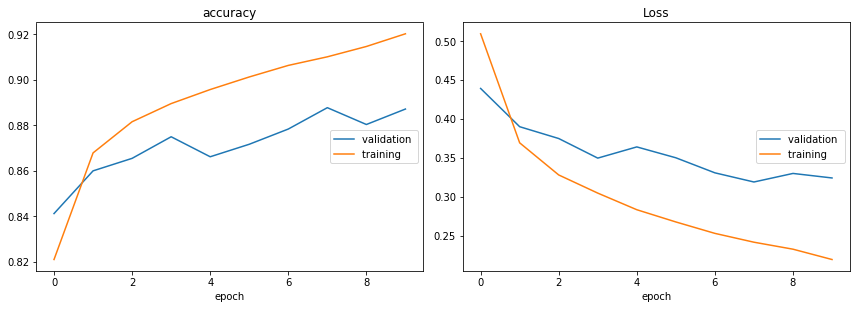

accuracy
	validation       	 (min:    0.841, max:    0.888, cur:    0.887)
	training         	 (min:    0.821, max:    0.920, cur:    0.920)
Loss
	validation       	 (min:    0.319, max:    0.439, cur:    0.324)
	training         	 (min:    0.219, max:    0.509, cur:    0.219)
dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


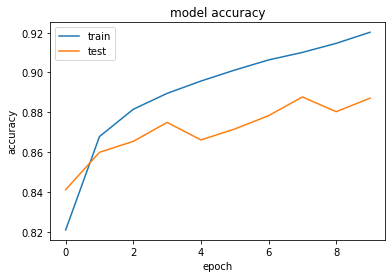

Scores:  [0.3239419683814049, 0.8870999813079834]
Erro modelo MLP: 11.29%


In [31]:
if __name__ == '__main__':
 #visualize_mnist()
 mnist_fashion_utilizando_mlp()